# Biblioteki

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
import seaborn as sns

from sklearn.model_selection import cross_val_score, learning_curve, ShuffleSplit, KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
# import catboost as ctb

import sys

# import scikitplot as skplt

from functools import partial
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance

# Dane

**Sales** - Historyczne dane sprzedaży.

- `store` - numer sklepu (sklep zawiera jeden lub więcej oddziałów)
- `dept` - numer oddziału
- `date` - tydzień (dane są zebrane w tygodniowe grupy)
- `weekly_sales` -  sprzedaż dla danego działu w danym sklepie
- `is_holiday` - czy tydzień jest specjalnym tygodniem (świątecznym). 


**Cechy dodatkowe** - Zawierają dodatkowe dane związane ze sklepem, działem i aktywnością regionalną w podanych terminach.

- `store` - the store number,
- `date` - tydzień (dane są zebrane w tygodniowe grupy),
- `temperature` - średnia temperatura w regionie,
- `fuel_price` - koszt paliwa w regionie,
- `mark_down1-5` - zanonimizowane dane związane z promocyjnymi obniżkami cen. Dane `mark_down` są dostępne dopiero po listopadzie 2011 i nie są dostępne dla wszystkich sklepów przez cały czas. Wszelkie brakujące wartości są oznaczone NA.
- `cpi` - indeks cen konsumpcyjnych (ang. `the consumer price index`),
- `unemployment` - stopa bezrobocia,
- `is_holiday` - czy tydzień jest specjalnym tygodniem świątecznym.

**Store** - Informacje dotyczące rodzaju oraz wielkości sklepu.

In [92]:
path = 'C:/Users/Hp/materialy/programowanie/DataScience/DataWorkshop_z_ruskim/data/'
df_sales_train = pd.read_hdf(path +"sales_train.h5")
df_sales_test = pd.read_hdf(path + "sales_test.h5")

df_sales_train["date"] = pd.to_datetime(df_sales_train["date"], format = '%d/%m/%Y')
df_sales_test["date"] = pd.to_datetime(df_sales_test["date"], format = '%d/%m/%Y')

df_features_train = pd.read_hdf( path +"features_train.h5")
df_features_test = pd.read_hdf(path + "features_test.h5")

df_features_train["date"] = pd.to_datetime(df_features_train["date"], format = '%d/%m/%Y')
df_features_test["date"] = pd.to_datetime(df_features_test["date"], format = '%d/%m/%Y')

df_store = pd.read_csv(path + "stores_data.csv")
print(df_store.shape)

df_store.columns = ["store", "type", "size"]
df_store['type_cat'] = df_store['type'].factorize()[0]
df_store.drop(columns=['type'],inplace=True)


(45, 3)


# vizualizacja

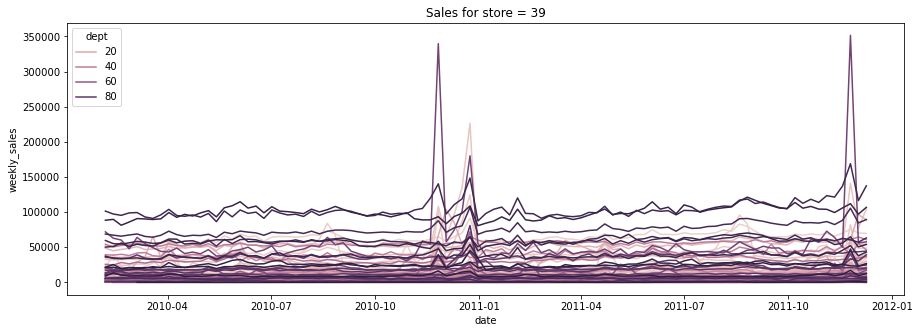

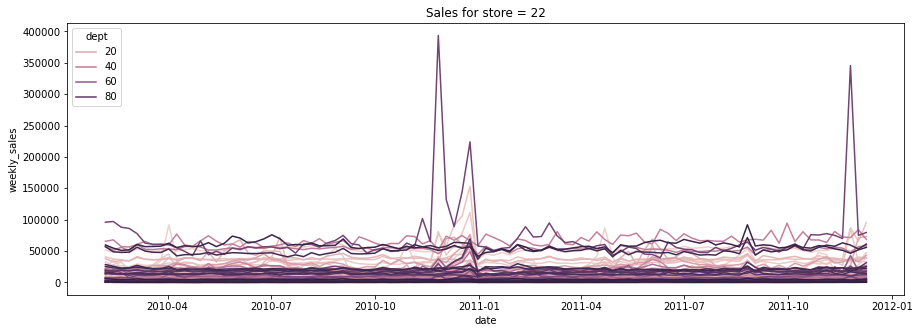

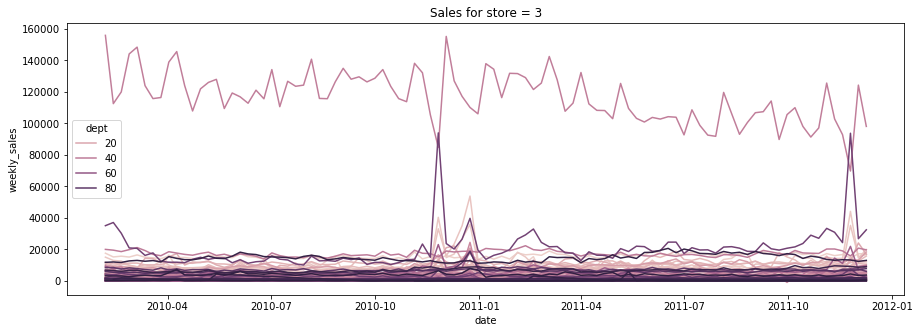

In [106]:
for i in range(3):
    random_store = df_sales_train.store.sample().values[0]
    plt.title("Sales for store = {}".format(random_store))
    sns.lineplot(x='date', y='weekly_sales', hue="dept", data=df_sales_train[df_sales_train.store == random_store]);
    plt.show()

In [108]:
#ok daty sie nie zazebiają 
pd.concat([df_features_train.date.agg([min, max]).reset_index(),df_features_test.date.agg([min, max]).reset_index()])

,index,date
0,min,2010-02-05
1,max,2011-12-09
0,min,2011-12-16
1,max,2013-07-26


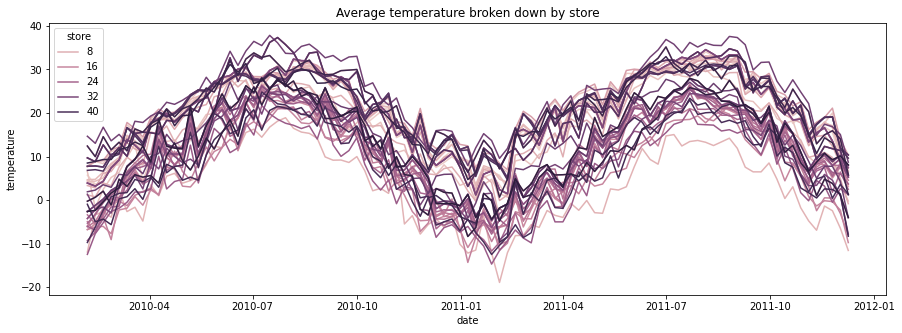

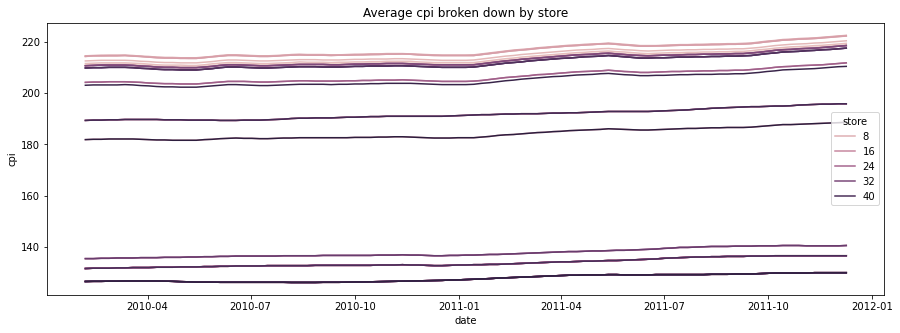

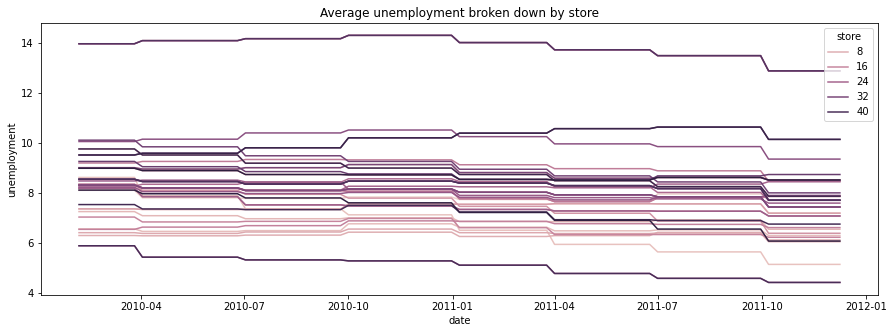

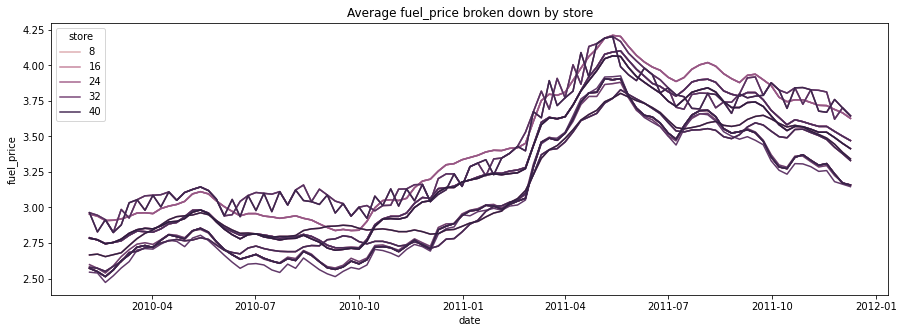

In [117]:
cechy = ['temperature', 'cpi', 'unemployment', 'fuel_price']
for i in cechy:    
    plt.title("Average {} broken down by store".format(i))
    sns.lineplot(x='date', y=i, hue='store', data=df_features_train);
    plt.show()


# Połączenie danych w jedną ramkę + inżynieria cech

In [93]:
def var_target_log(y, offset):
    log_y = np.log(y-offset)
    return log_y

def var_target_exp(log_y, offset):
    y = np.exp(log_y)+offset
    return y

#logarytmowanie zmiennej docelowej   
offset = df_sales_train['weekly_sales'].min()-1
df_sales_train['log_weekly_sales'] = df_sales_train['weekly_sales'].map(lambda x: var_target_log(x,offset))

def simple_feature_engineering(df):
    #operacje na datach
    df['month'] = df["date"].dt.month
    df['year'] = df["date"].dt.isocalendar().year
    df['week'] = df["date"].dt.isocalendar().week
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    
    #ID/identyfikator dla kombinacji sklep-oddzial
    df['id-store-dept'] = df[['store','dept']].apply(lambda x: x['store']*1000 + x['dept'], axis=1)
    
    #liczba oddzialow 
    temp_sum_dept = df_sales_train.groupby('store')['dept'].nunique() # 1     77 --> [1]
    df['sum_dept'] = df['store'].apply(lambda x: temp_sum_dept[x])
    
    #doklejanie info ze df_store -->store	size	type_ca
    df = pd.merge(df, df_store, on = ['store'], how='left')
    
    
    # 3:
    #przypisanie sredniej ceny z przeszlosci (analogiczny okres roku poprzedniego, sprzedaz zlogarytmowana)
    
    df["year_minus_1"] = df["year"] - 1
    
    df_sales_group = df_sales_train.groupby(["id-store-dept", "year", "week"]).agg("mean")[ ["log_weekly_sales"] ].reset_index()
    df_sales_group = df_sales_group.rename(columns={'year': 'year_minus_1',
                                                   'log_weekly_sales': 'PY_week_log_sales'})
    
    df = pd.merge(df, df_sales_group, on = ['id-store-dept', 'year_minus_1', 'week'], how = 'left')

    df_sales_group_2 = df_sales_train.groupby(["id-store-dept", "year", "month"]).agg("mean")[ ["log_weekly_sales"] ].reset_index()
    df_sales_group_2 = df_sales_group_2.rename(columns={'year': 'year_minus_1',
                                                   'log_weekly_sales': 'PY_month_log_sales'})

    df = pd.merge(df, df_sales_group_2, on = ['id-store-dept', 'year_minus_1', 'month'], how = 'left')
    
    # 4
    #przypisanie podst. charakterystyk dot. sklepu  (sprzedaz zlogarytmowana)

    df_store_stats = df_sales_train.groupby(["store"]).agg(["mean", "std", "median", "size"])["log_weekly_sales"].reset_index()
    df_store_stats.rename(columns= { 
                                'mean': 'store_mean', 
                                'std': 'store_std', 
                                'median': 'store_median', 
                                'size': 'store_size'},
                      inplace = True
                     )
 
    df_store_stats_dept = df_sales_train.groupby(['store','dept']).agg(["mean", "std", "median", "size"])["log_weekly_sales"].reset_index()
    df_store_stats_dept.rename(columns= { 
                                'mean': 'dept_mean', 
                                'std': 'dept_std', 
                                'median': 'dept_median', 
                                'size': 'dept_size'},
                      inplace = True
                     )


    df = pd.merge(df, df_store_stats, on = ['store'], how = 'left')
    df = pd.merge(df, df_store_stats_dept, on = ['store', 'dept'], how = 'left'
                 )
    #dodatek 
    df['black_friday'] = df['date'].isin(['2011-11-25','2010-11-26','2012-11-23', '2013-11-29']).astype(int)
    df['store_size_cat'] = df['size'].map(lambda x: 0 if x < 75000 else 2 if x > 175000 else 1)
    #braki danych
    df.fillna(-1, inplace = True)
    
    return df


df_sales_train = simple_feature_engineering(df_sales_train)
df_sales_test = simple_feature_engineering(df_sales_test)


## Dodanie dodatkowych cech z df_features_train do modelu:
    ## df_sales_test - zakladam, ze wartosci beda takie same jak w analogicznym okresie roku poprzedniego
    
df_features_train['year_minus_1']= df_features_train['date'].dt.year #klucz do polaczenia z df_sales_test
df_features_train['month']= df_features_train['date'].dt.month #klucz do polaczenia z df_sales_test
     
feat_vars_train = ['store', 'date', 'temperature', 'fuel_price',
                   'cpi', 'unemployment']
feat_vars_test = ['store', 'year_minus_1', 'month', 'temperature', 'fuel_price',
                   'cpi', 'unemployment']

df_sales_train = pd.merge(df_sales_train, df_features_train[feat_vars_train], on = ['store', 'date'], how = 'left')

predicted_features = df_features_train[feat_vars_test].groupby(['store', 'year_minus_1', 'month']).agg('mean')[['temperature', 'fuel_price', 'cpi', 'unemployment']].reset_index()
df_sales_test = pd.merge(df_sales_test, predicted_features, on = ['store', 'year_minus_1', 'month'], how = 'left')


C:\Users\Hp\AppData\Local\Temp\ipykernel_10524\3910079551.py:52: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_store_stats = df_sales_train.groupby(["store"]).agg(["mean", "std", "median", "size"])["log_weekly_sales"].reset_index()
C:\Users\Hp\AppData\Local\Temp\ipykernel_10524\3910079551.py:61: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_store_stats_dept = df_sales_train.groupby(['store','dept']).agg(["mean", "std", "median", "size"])["log_weekly_sales"].reset_index()
C:\Users\Hp\AppData\Local\Temp\ipykernel_10524\3910079551.py:52: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_store_stats = df_sal

In [118]:
pd.set_option('display.max_columns', None)
df_sales_train.head(1)
# df['size']

,id,weekly_sales,store,dept,date,is_holiday,log_weekly_sales,month,year,week,dayofweek,dayofyear,id-store-dept,sum_dept,size,type_cat,year_minus_1,PY_week_log_sales,PY_month_log_sales,store_mean,store_std,store_median,store_size,dept_mean,dept_std,dept_median,dept_size,black_friday,store_size_cat,temperature,fuel_price,cpi,unemployment
0,1,41272.601562,42,94,2010-07-09,False,10.742088,7,2010,27,4,190,42094,60,39690,2,2009,-1.0,-1.0,9.293385,0.851241,8.763504,4606,10.591222,0.090306,10.588966,97,0,0,32.78125,3.099609,126.125,9.195312


In [123]:
df_sales_train.shape, df_sales_test.shape

((285089, 33), (136481, 31))

# Model - wersja podstawowa 

* Logarytmuję zmienną docelową
* Biorę pod uwagę dwa modele: XGBoost i Catboost

In [119]:
# TRENOWANIE I WALIDACJA MODELU
def var_target_log(y, offset):
    log_y = np.log(y-offset)
    return log_y

def var_target_exp(log_y, offset):
    y = np.exp(log_y)+offset
    return y

def get_models():

    xgb_params = {    
        'max_depth': 6, 
        'n_estimators': 100,
        'learning_rate': 0.2, 
        'subsample': 0.5, 
        'random_state':0, 
        'colsample_bytree': 0.9
    }

    ctb_params = {
        'n_estimators': 100, 
        'depth': 6, 
        'random_state':0, 
        'verbose': False
    }
    
    
    return [
         ('xgb', xgb.XGBRegressor(**xgb_params)),
         ('ctb', ctb.CatBoostRegressor(**ctb_params))
    ]

def run_cv(model, X, y, target_var_offset, folds=3, cv_type=KFold, success_metric=mean_absolute_error):
    cv = cv_type(n_splits=folds)
    
    scores = []
    kaggle_ind = 0
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        y_train_log = var_target_log(y_train, target_var_offset)
        
        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_test)
        
        y_pred = var_target_exp(y_pred_log, target_var_offset)
        
        score = success_metric(y_test, y_pred)
        scores.append( score )
              
    return np.mean(scores), np.std(scores)




def run(X, y, target_var_offset, folds=3):

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y,target_var_offset = target_var_offset, folds=folds)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania

        
def fit_and_predict(model_cls, model_params, X_train, X_test, y_train, target_var_offset):

    y_train_log = var_target_log(y_train, target_var_offset)

    model = model_cls(**model_params)
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
        
    y_pred = var_target_exp(y_pred_log, target_var_offset)
    
    return y_pred



# ELI5 + feature importance plot
def fi_ocena(X,y,target_var_offset, FEATS, model_indx=0):
    y_log = var_target_log(y, target_var_offset)

    model_name, model = get_models()[model_indx]
    model.fit(X,y_log)
    
    imp = PermutationImportance(model, random_state=0).fit(X,y_log)

    title='Feature Importance. {0}'.format(model_name)
    skplt.estimators.plot_feature_importances(model, feature_names=FEATS, title=title, x_tick_rotation=90, figsize=(15, 5));
    res_eli5 = eli5.show_weights(imp, feature_names=FEATS, top=30)
    return res_eli5



### Walidacja krzyżowa + Feature Importance
Obliczenia wykonuję na połowie zbioru, żeby oszczędzić na czasie

In [120]:
temp_df_train = df_sales_train.sample(frac = 0.5)
print(temp_df_train.shape)

feats = [x for x in temp_df_train.columns if x not in ['id',
                                                       'weekly_sales', 
                                                       'log_weekly_sales', 
                                                       'date', 
                                                       'year_minus_1']]
#temp_df_train[feats].head()

(142544, 33)


**XGBoost**

Weight,Feature
0.9018 ± 0.0050,dept_mean
0.0720 ± 0.0006,PY_week_log_sales
0.0520 ± 0.0003,dept_median
0.0288 ± 0.0001,PY_month_log_sales
0.0208 ± 0.0002,dept_std
0.0162 ± 0.0002,week
0.0100 ± 0.0002,dept
0.0061 ± 0.0002,dayofyear
0.0059 ± 0.0001,dept_size
0.0037 ± 0.0001,year


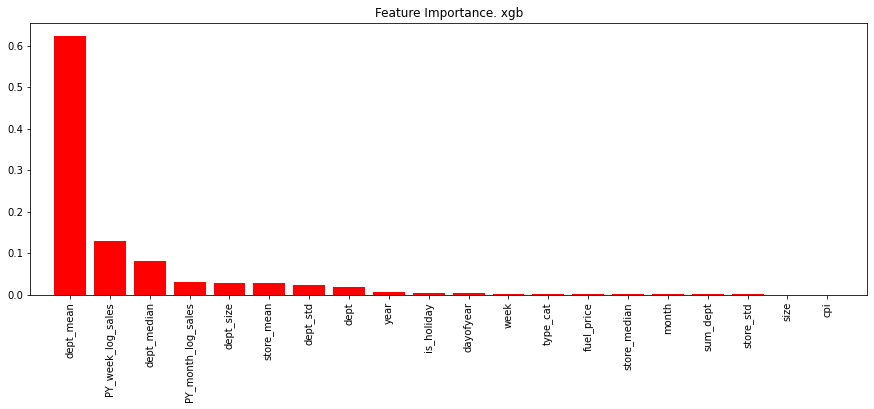

In [12]:
fi_ocena(temp_df_train[feats].values, temp_df_train['weekly_sales'].values, df_sales_train['weekly_sales'].min()-1, feats,0)

**Catboost**

Weight,Feature
0.9737 ± 0.0037,dept_mean
0.1201 ± 0.0002,dept_median
0.1006 ± 0.0008,PY_week_log_sales
0.0374 ± 0.0003,PY_month_log_sales
0.0245 ± 0.0003,dept_std
0.0172 ± 0.0003,dayofyear
0.0101 ± 0.0004,dept
0.0081 ± 0.0001,week
0.0065 ± 0.0002,dept_size
0.0050 ± 0.0001,year


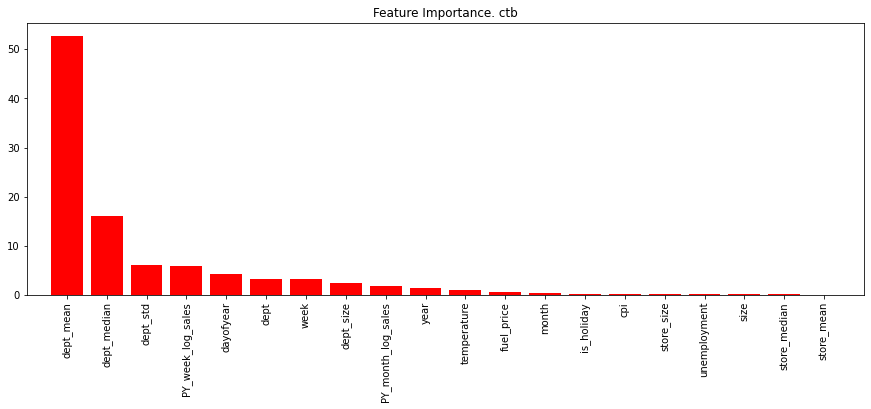

In [13]:
fi_ocena(temp_df_train[feats].values, temp_df_train['weekly_sales'].values, df_sales_train['weekly_sales'].min()-1, feats,1)

#### Model -  wszystkie cechy

In [14]:
run(temp_df_train[feats].values, temp_df_train['weekly_sales'].values, df_sales_train['weekly_sales'].min()-1, folds=3)

[xgb]: 1760.3265380859375 +/-7.760250091552734
[ctb]: 1816.7880239380038 +/-14.689259544364036


#### Model -  Eli5

In [15]:
feat_eli5 = [
'dept_mean',
'PY_week_log_sales',
'dept_median',
'PY_month_log_sales',
'dept_std',
'week',
'dept',
'dayofyear',
'dept_size',
'fuel_price',
'year',
'temperature',
'month',
'size',
'cpi', 
'store_size',
'store_median'
]


run(temp_df_train[feat_eli5].values, temp_df_train['weekly_sales'].values, df_sales_train['weekly_sales'].min()-1, folds=3)

[xgb]: 1730.43701171875 +/-19.016374588012695
[ctb]: 1808.025409175925 +/-27.11210715201842


**Wnioski**: zawężam się do zbioru cech z Eli5. 

## Hyperopt
Optymalizację parametrów robię na pełnym zbiorze (relatywnie szybko się liczy)

In [18]:
train_hyperopt = df_sales_train
FEATS = feat_eli5
target_var_offset = df_sales_train['weekly_sales'].min()-1


# definiowanie przestrzeni parametrow do optymalizacji

space_xgb ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50)
}

space_ctb = {
    'depth': hp.quniform ('x_depth', 5, 16, 1), 
    'random_state':hp.quniform ('x_random_state', 0, 10000, 50), 
}


# funkcja do optymalizacji

def objective_xgb(space):
    
    X, y = train_hyperopt[FEATS].values, train_hyperopt['weekly_sales'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    xgb_params = {
        'max_depth': int(space['max_depth']), 
        'colsample_bytree': space['colsample_bytree'], 
        'learning_rate': space['learning_rate'], 
        'subsample': space['subsample'], 
        'random_state': int(space['random_state']),
        'n_estimators': 100, 
    }
    
    y_pred = fit_and_predict(model_cls=xgb.XGBRegressor, model_params=xgb_params, 
                             X_train=X_train, X_test=X_test, y_train=y_train,
                            target_var_offset=target_var_offset)
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }

def objective_ctb(space):
    
    X, y = train_hyperopt[FEATS].values, train_hyperopt['weekly_sales'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
      
    ctb_params = {
        'n_estimators': 100, 
        'depth': int(space['depth']), 
        'random_state':int(space['random_state']), 
        'verbose': False
    }
    
    y_pred = fit_and_predict(model_cls=ctb.CatBoostRegressor, model_params=ctb_params, 
                             X_train=X_train, X_test=X_test, y_train=y_train,
                            target_var_offset=target_var_offset)

    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }



In [19]:
trials = Trials()
best_params = fmin(fn=objective_xgb,
            space=space_xgb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("XGB The best params: ", best_params)

100%|██████████| 30/30 [19:20<00:00, 38.69s/trial, best loss: 1131.13720703125]
XGB The best params:  {'x_colsample_bytree': 0.8444849025283869, 'x_learning_rate': 0.09709482828841624, 'x_max_depth': 18.0, 'x_random_state': 10000.0, 'x_subsample': 0.9987817497861815}


In [20]:
trials = Trials()
best_params = fmin(fn=objective_ctb,
            space=space_ctb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("CTB The best params: ", best_params)

100%|██████████| 30/30 [14:45<00:00, 29.51s/trial, best loss: 1324.2996079181028]
CTB The best params:  {'x_depth': 15.0, 'x_random_state': 9000.0}


# Trenowanie finalnego modelu

In [22]:
final_feats = feat_eli5
final_target_offset = df_sales_train['weekly_sales'].min()-1


# optymalne wartosci parametrow - hyperopt

xgb_best_params = {
                   'colsample_bytree': 0.8444849025283869, 
                   'learning_rate': 0.09709482828841624, 
                   'max_depth': 18, 
                   'random_state': 10000, 
                   'subsample': 0.9987817497861815,
                   'n_estimators': 100
                    }

ctb_best_params = {
    'n_estimators': 100, 
    'depth': 15, 
    'random_state':9000, 
    'verbose': False
}


X_train, X_test = df_sales_train[final_feats].values, df_sales_test[final_feats].values



In [23]:
# XGBoost
kaggle_y_pred_xgb = fit_and_predict(model_cls=xgb.XGBRegressor, model_params=xgb_best_params, 
                                    X_train=X_train, X_test=X_test, y_train=df_sales_train['weekly_sales'].values,
                                   target_var_offset=final_target_offset)

In [24]:
# Catboost
kaggle_y_pred_ctb = fit_and_predict(model_cls=ctb.CatBoostRegressor, model_params=ctb_best_params, 
                                     X_train=X_train, X_test=X_test, y_train=df_sales_train['weekly_sales'].values,
                                   target_var_offset=final_target_offset)

In [25]:
!mkdir -p ../output

In [26]:
# zapis do pliku - XGBoost
df_sales_test['weekly_sales'] = kaggle_y_pred_xgb
df_sales_test[ ["id", "weekly_sales"] ].to_csv("../output/xgb_hyperopt_v1.csv", index=False)

In [27]:
# zapis do pliku - Catboost
df_sales_test['weekly_sales'] = kaggle_y_pred_ctb
df_sales_test[ ["id", "weekly_sales"] ].to_csv("../output/cbt_hyperopt_v1.csv", index=False)

In [28]:
# srednia arytmetyczna XGBoost i Catboost
kaggle_y_mean = (kaggle_y_pred_xgb + kaggle_y_pred_ctb)/2

In [29]:
# zapis do pliku - srednia arytmetyczna
df_sales_test['weekly_sales'] = kaggle_y_mean
df_sales_test[ ["id", "weekly_sales"] ].to_csv("../output/mean_xgb_cbt_hyperopt_v1.csv", index=False)